### Ejemplo de entrenamiento de Modelo

Algunos enlaces para poder leer sobre este tipo de procedimientos

* https://keras.io/examples/vision/conv_lstm/ (Ejemplo que funciona como base para entrenar un modelo con el metodo ConvLSTM)
* https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7
* https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf
* https://medium.com/@rajin250/precipitation-prediction-using-convlstm-deep-neural-network-b9e9b617b436 
* https://github.com/TeaPearce/precipitation-prediction-convLSTM-keras (Repositorio del articulo anterior)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

### Se carga los archivos con las matrices para el entrenamiento

In [2]:
%%time
dataset = np.load("historial_1D.npy")

CPU times: user 597 µs, sys: 4.83 ms, total: 5.43 ms
Wall time: 4.48 ms


## Forma de los datos

El conjunto de datos consta de 98 secuencias de 5 imagenes de 40x40


In [3]:
dataset.shape

(98, 5, 40, 40)

Esto permite ver si se detecta correctamente una grafica, en muchos procesos de entrenamientos se logra una reduccion de tiempos utilizando GPUs.

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [4]:

# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)
dataset.shape

(98, 5, 40, 40, 1)

* Se normalizan los datos entre 0 y 1 (En este ejemplo no es necesario ya que el valor maximo posible es 1)

* Se utiliza el 80% de los datos para entrenamiento y otro 20% para validacion


In [5]:

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.8 * dataset.shape[0])]
val_index = indexes[int(0.8 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]



#Los datos ya estan entre 0 y 1 

# Normalize the data to the 0-1 range.
#train_dataset = train_dataset / 255
#val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (78, 4, 40, 40, 1), (78, 4, 40, 40, 1)
Validation Dataset Shapes: (20, 4, 40, 40, 1), (20, 4, 40, 40, 1)


### Visualizacion de un ejemplo de secuencia

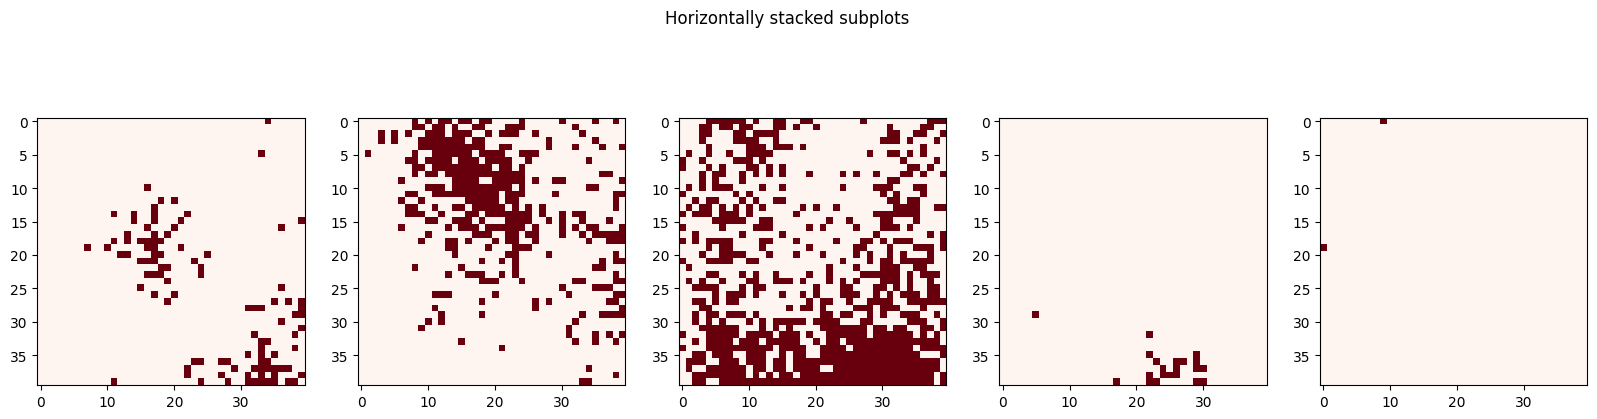

In [6]:


# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]



fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,5))
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(train_dataset[data_choice][0], cmap='Reds', vmin=0, vmax=1)
ax2.imshow(train_dataset[data_choice][1], cmap='Reds', vmin=0, vmax=1)
ax3.imshow(train_dataset[data_choice][2], cmap='Reds', vmin=0, vmax=1)
ax4.imshow(train_dataset[data_choice][3], cmap='Reds', vmin=0, vmax=1)
ax5.imshow(train_dataset[data_choice][4], cmap='Reds', vmin=0, vmax=1)


### Construccion del modelo

Aqui se podria modificar en base a muchas variables como el tipo de conjunto de datos, cuantos datos se  tienen, que tan complejo es el problema entre otras cosas, en general se toma de base modelo y se va analizando posibles cambios que se puedan realizar.

In [7]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

### Resumen del modelo

In [8]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 40, 40, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 40, 40, 64)  416256    
                                                                 
 batch_normalization (BatchN  (None, None, 40, 40, 64)  256      
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 40, 40, 64)  295168    
                                                                 
 batch_normalization_1 (Batc  (None, None, 40, 40, 64)  256      
 hNormalization)                                                 
                                                             

### Se entrena el modelo

In [11]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
16/16 [==============================] - 1s 55ms/step - loss: 0.0782 - val_loss: 0.4754 - lr: 1.0000e-05
Epoch 2/20
16/16 [==============================] - 1s 52ms/step - loss: 0.0776 - val_loss: 0.4717 - lr: 1.0000e-05
Epoch 3/20
16/16 [==============================] - 1s 53ms/step - loss: 0.0781 - val_loss: 0.4642 - lr: 1.0000e-05
Epoch 4/20
16/16 [==============================] - 1s 53ms/step - loss: 0.0784 - val_loss: 0.4525 - lr: 1.0000e-05
Epoch 5/20
16/16 [==============================] - 1s 52ms/step - loss: 0.0776 - val_loss: 0.4353 - lr: 1.0000e-05
Epoch 6/20
16/16 [==============================] - 1s 52ms/step - loss: 0.0787 - val_loss: 0.4128 - lr: 1.0000e-05
Epoch 7/20
16/16 [==============================] - 1s 52ms/step - loss: 0.0773 - val_loss: 0.3867 - lr: 1.0000e-05
Epoch 8/20
16/16 [==============================] - 1s 53ms/step - loss: 0.0788 - val_loss: 0.3582 - lr: 1.0000e-05
Epoch 9/20
16/16 [==============================] - 1s 52ms/step - loss:

### Se utiliza el modelo para predecir la 5 imagen y se visualiza.

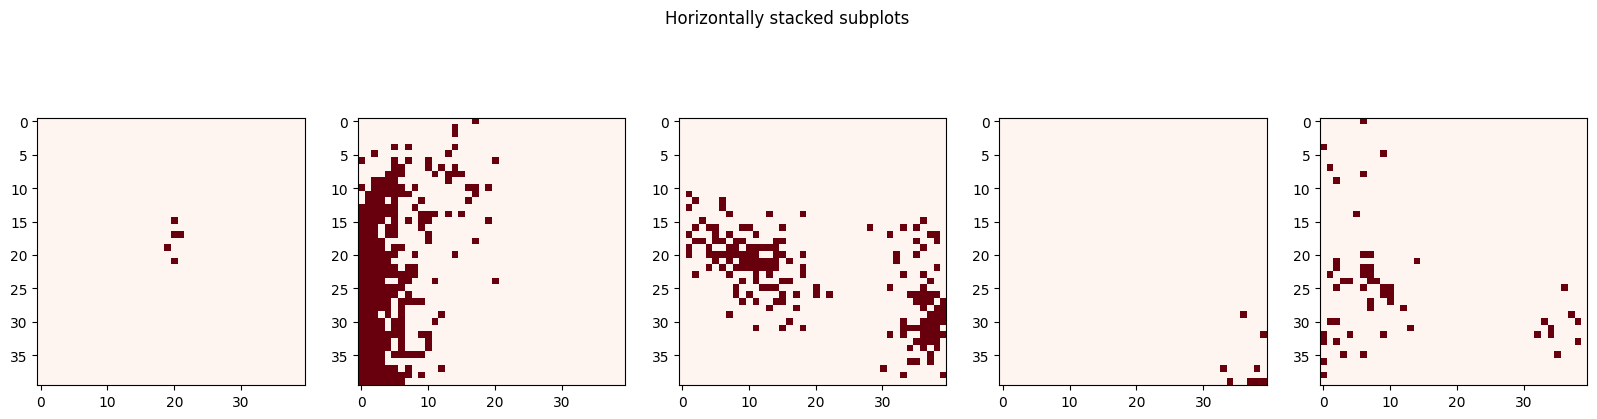

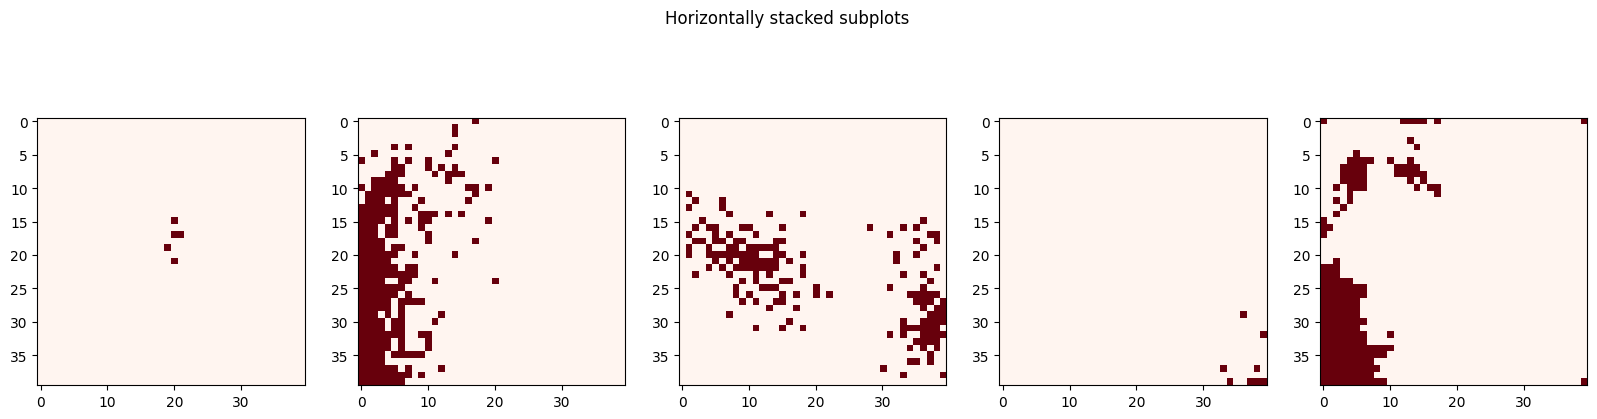

In [79]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:4, ...]
original_frames = example[4:, ...]


# Extract the model's prediction and post-process it.
new_prediction = model.predict(np.expand_dims(frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

# Extend the set of prediction frames.
frames = np.concatenate((frames, predicted_frame), axis=0)


    
    
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,5))
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(np.squeeze(frames[-5]), cmap='Reds', vmin=0, vmax=1)
ax2.imshow(np.squeeze(frames[-4]), cmap='Reds', vmin=0, vmax=1)
ax3.imshow(np.squeeze(frames[-3]), cmap='Reds', vmin=0, vmax=1)
ax4.imshow(np.squeeze(frames[-2]), cmap='Reds', vmin=0, vmax=1)
ax5.imshow(np.squeeze(np.where(original_frames[-1] > 0.5, 1, 0)), cmap='Reds', vmin=0, vmax=1)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,5))
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(np.squeeze(frames[-5]), cmap='Reds', vmin=0, vmax=1)
ax2.imshow(np.squeeze(frames[-4]), cmap='Reds', vmin=0, vmax=1)
ax3.imshow(np.squeeze(frames[-3]), cmap='Reds', vmin=0, vmax=1)
ax4.imshow(np.squeeze(frames[-2]), cmap='Reds', vmin=0, vmax=1)
ax5.imshow(np.squeeze(np.where(frames[-1] > frames[-1].max()*.5, 1, 0)), cmap='Reds', vmin=0, vmax=1)



# Display the figure.
plt.show()



* En el primer renglon esta la secuencia de 5 imagenes original.


* En la segunda estan 4 frames originales y la 5 representa la prediccion que el modelo predijo

* La unica modificacion que le hago a la prediccion es aplicarle un limite para definir que sea 0 o 1 el valor en cada zona para poder visualizarlo de mejor manera